# Computing with Text: Counting words
## Turning Text into Vectors

In many different Data Science projects or tasks, we often find ourselves needing to transform our data into a format that is more suitable for computation and analysis. When dealing with textual data, this means converting our words into numeric representations, often in the form of vectors. But why vectors, you may ask? Machine Learning algorithms, at their core, work with numerical data. They're able to identify patterns, trends, and relationships within numeric data much more effectively. Numerical vectors are a very suitable input for machine learning models. In addition, such vectors allow direct use of methods from algebra, for instance to computed distances or similarities between data points.

### Distance/similarity measures
Depending on the type of numerical vector there are many suitable methods to compute vector-vector similarities (or inverse: distances). For real-numbered (float) vectors we can for instance simply use the **Euclidean distance** which you will know from Pythagoras. Or a **Cosine similarity** based on the angle between two vectors. For binary vectors there are other measures such as the **Jaccard similarity**.

## One-Hot Encoding

The first step towards this transformation is to use a method known as **One-Hot Encoding**. In this process, each word in the sentence is represented as a vector in an N-dimensional space where N is the number of unique words in the sentence. Each word is represented as a vector of length N, with all elements being 0, except for one element which is 1, indicating the presence of the word.

For instance, consider the sentences: "I like cats" and "I like dogs". In a one-hot encoding scheme, these sentences would be represented by the vectors:

- I: [1, 0, 0, 0]
- like: [0, 1, 0, 0]
- cats: [0, 0, 1, 0]
- dogs: [0, 0, 0, 1]

With this encoding, we can calculate the Euclidean distance between these sentence vectors, providing a way to compare sentences. However, this method has limitations. The vectors can become extremely large for sentences with many unique words, and all words are treated as orthogonal, meaning the distance between any two different words is always the same, which is often not what we want.

For instance, consider the sentences:  
*"That is the one and only way to happiness."*  
and  
*"That is the one and only way to die."* 

Despite having only one word difference, the Euclidean distance between these sentences would be very small since only one word differs.
The distance between "happiness" and "die" is the same as between "That" and "This", even though the first has a much larger impact on the meaning of the sentence.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# That is the one and only way to happiness
vector1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
# That is the one and only way to die
vector2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])
# This is the one and only way to happiness
vector3 = np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])


distance = np.sqrt(np.sum(vector1 ** 2 + vector2 ** 2))
print(f"Distance between vector1 and vector2: {distance:.3f}.")

distance = np.sqrt(np.sum(vector1 ** 2 + vector3 ** 2))
print(f"Distance between vector1 and vector3: {distance:.3f}.")

Distance between vector1 and vector2: 4.243.
Distance between vector1 and vector3: 4.243.


## Term Frequency-Inverse Document Frequency (TF-IDF)

To resolve these issues, we use a more sophisticated method called **Term Frequency-Inverse Document Frequency (TF-IDF)**. This measure helps us to evaluate how important a word is to a document within a corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is composed of two terms:

- The Term Frequency (TF), which is the frequency of a word in a document. It is computed as: 

$$TF(t)=\frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}
$$


- The Inverse Document Frequency (IDF) is computed as the logarithm of the number of documents in the corpus divided by the number of documents where the specific term appears.

$$IDF(t)=\log(\frac{\text{Total number of documents}}{\text{Number of documents with term t in it}})
$$

- The TF-IDF weight is the product of these quantities:

$$\text{TF−IDF}=TF×IDF$$

This results in a vector space model where each word is assigned a TF-IDF score, and a document is represented as a vector of these scores. We can use libraries like `Scikit-Learn`{cite}`scikit-learn` to compute these scores easily.

Finally, we can use these TF-IDF vectors to train Machine Learning models. For example, we can train a logistic regression model (see {numref}`ch_linear_models`) for sentiment analysis. 

In this chapter, and the next one, we will see that turning words into vectors is a fundamental approach in NLP that opens up countless new possibilities for analysis and model training.

## Hands-on: Hotel Reviews
Let's work with some actual data!

We here will work with a dataset of about 20,000 hotel reviews from TripAdvisor ([see original dataset on zenodo](https://zenodo.org/records/1219899) or [see dataset on kaggle](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)). The goal will be to train a machine learning model to predict hotel ratings based on a review text.

#### Data import and exploration
As in the former chapters, we import the data using `Pandas`. We will then explore the data a bit. However, since this dataset was already prepared to work for machine learning tasks in this case, there are no complicated data processing steps that we have to do at this point.

In [3]:
"""
This code block downloads the data from zenodo and stores it in
a local 'datasets' folder.
"""

import requests
import os


def download_from_zenodo(url, save_path):
    """
    Downloads a file from a given Zenodo link and saves it to the specified path.

    Parameters:
    - url: The Zenodo link to the file to be downloaded.
    - save_path: Path where the file should be saved.
    """

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File {save_path} already exists. Skipping download.")
        return None

    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File downloaded successfully and saved to {save_path}")


# Zenodo link to the dataset
zenodo_link = r"https://zenodo.org/records/1219899/files/b.csv?download=1"

# Path to save the downloaded dataset (you can modify this as needed)
output_path = os.path.join("..", "datasets", "tripadvisor_hotel_reviews.csv")

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Download the dataset
download_from_zenodo(zenodo_link, output_path)

File ..\datasets\tripadvisor_hotel_reviews.csv already exists. Skipping download.


In [4]:
filename = "../datasets/tripadvisor_hotel_reviews.csv"
try:
    data = pd.read_csv(filename, encoding="UTF-16LE")
except UnicodeDecodeError:
    data = pd.read_csv(filename, encoding="cp1252")
data.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   S.No.   20491 non-null  int64 
 1   Review  20491 non-null  object
 2   Rating  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


Text(0.5, 1.0, 'Rating Distribution')

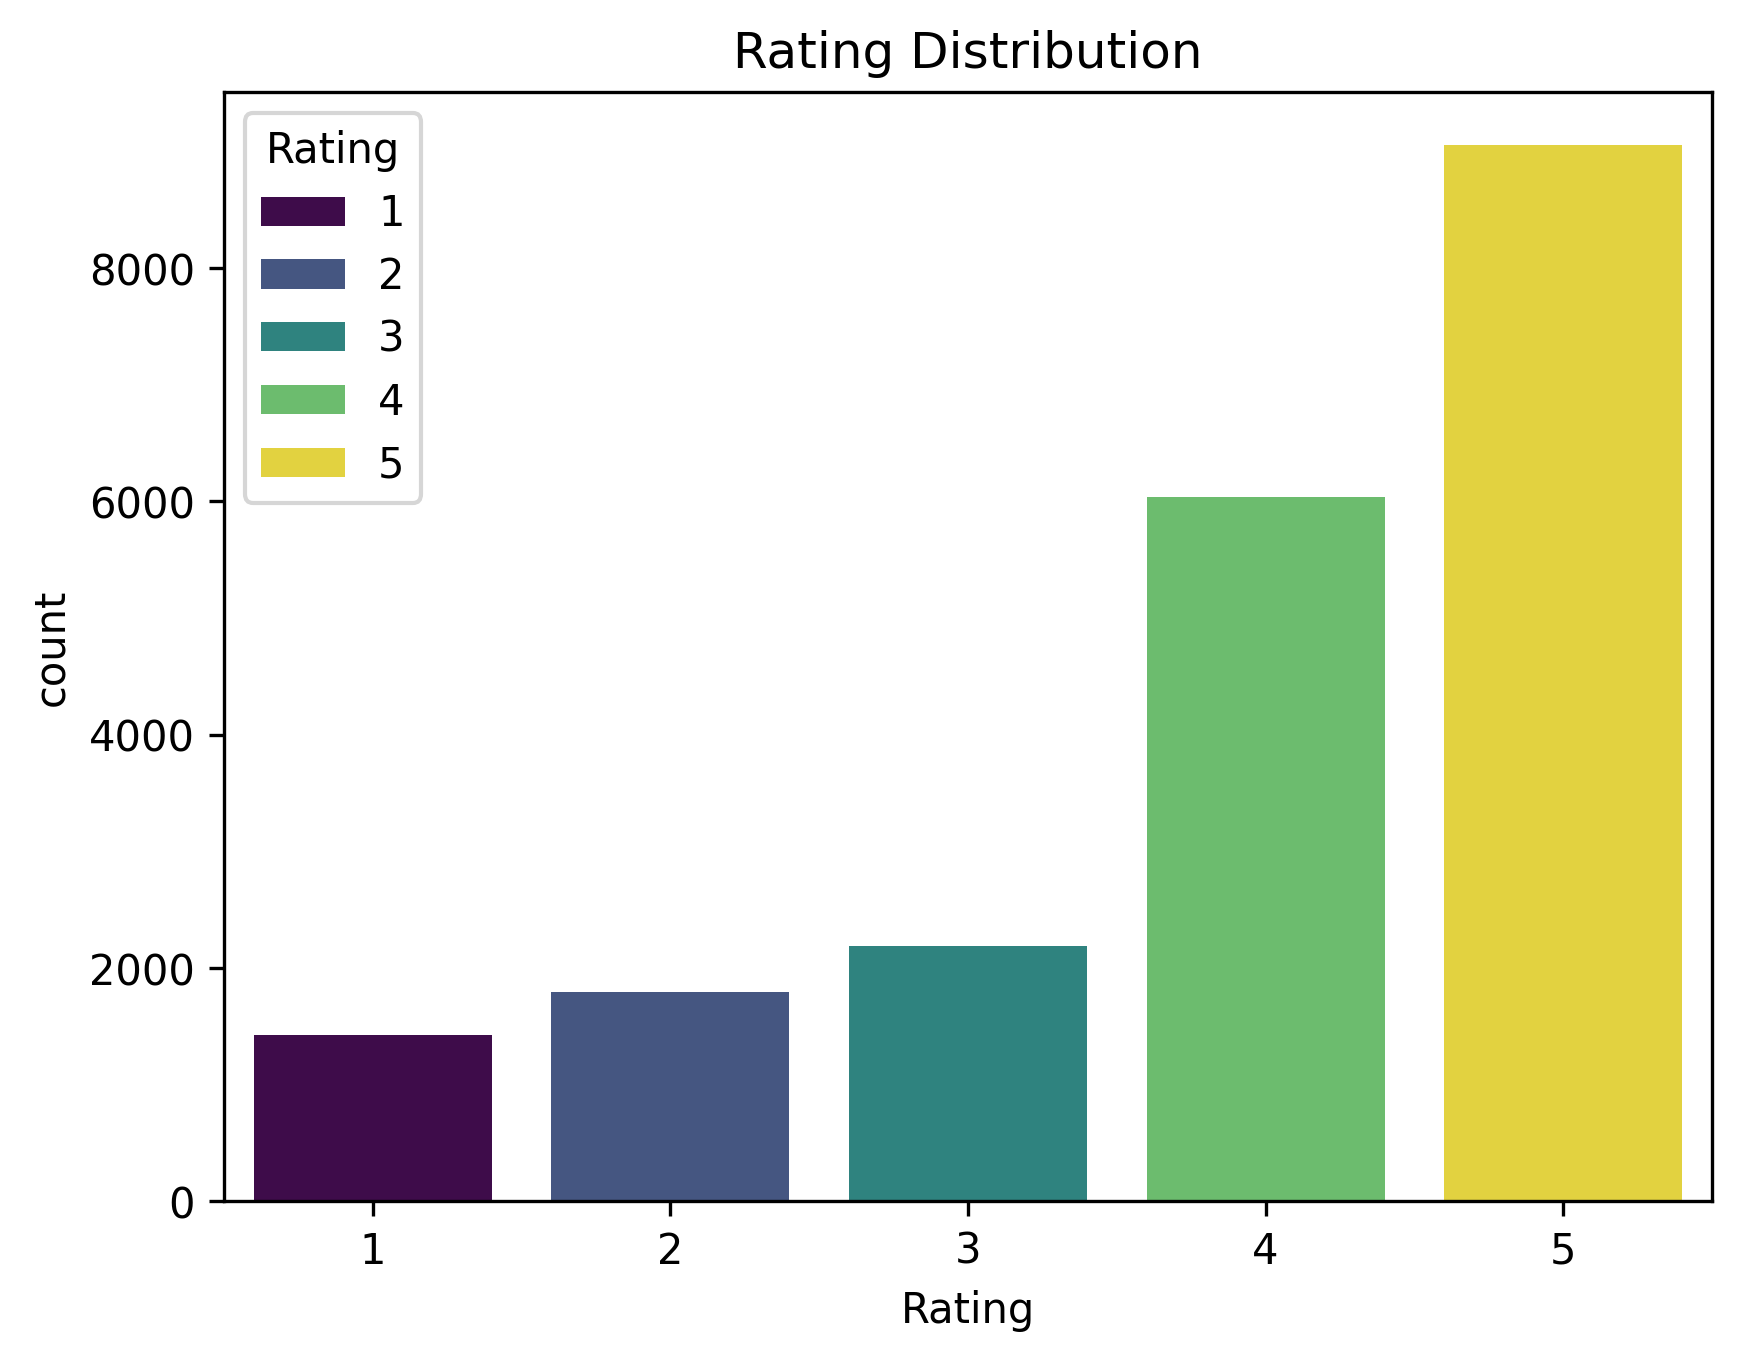

In [6]:
plt.figure(dpi=300)
sb.countplot(data=data,
             x="Rating",
             palette="viridis",
             hue="Rating",
            ).set_title("Rating Distribution")


Here we see a first potential issue, a **bias of the ratings**. The dataset contains far more positive reviews (>= 4) than neutral or negative ones. This is a common problem in machine learning and there are strategies to deal with this (e.g. *oversampling* or using *class weights*), but for now we will simply ignore it.

### Train/Test Split

Let us first split the data into a training and test set (see chapters on machine learning!).

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['Review'], data['Rating'], test_size=0.2, random_state=0)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")    

Train dataset size: (16392,)
Test dataset size: (4099,)


In [8]:
tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(X_train)
tfidf_vectors.shape

(16392, 46813)

This is a pretty big array (or matrix). So, how does such a tfidf vector look like, for instance the tfidf-vector for the first review?

In [9]:
# This is the review
data.iloc[0, 0]

1

In [10]:
# And this is the tfidf-vector of this review
tfidf_vectors[0, :]

<1x46813 sparse matrix of type '<class 'numpy.float64'>'
	with 247 stored elements in Compressed Sparse Row format>

#### What does `sparse matrix` mean?
We have seen before, that such sentence (or text) vector can quickly become very long. Here each vector as 47073 positions, one for each word. But most of these words do not occur in a particular sentence, so most positions in a tfidf-vector are simply `0`.

To save all those numbers would be very vastefull memory wise. So, scikit-learn here uses so called `sparse matrices` which only store the data for non-zero positions. We can look at the data with the `.data` attribute. Or we can convert it to a dense vector (that includes all zeros) by using `.toarray()`.

### Reduce tfidf vector size
So far we simply used the `TfidfVectorizer` without setting any parameters, which means that it will simply use default values. In our case, however, we end up with rather large tfidf vectors. In particular given the relatively small dataset (small for NLP standards) and the rather short reviews.

In many cases, and here as well, we also deal with text data of strongly varying quality. This can lead to many words in the `tfidf model` which are not meaningfull enough. We can have a look at the words which were included:

In [11]:
# Have a look at the last 100 words in the tfidf model
tfidf.get_feature_names_out()[-100:]

array(['zones', 'zonethis', 'zoning', 'zoo', 'zoogarten', 'zooji',
       'zoological', 'zoologicher', 'zoologische', 'zoologischer',
       'zoologisher', 'zoom', 'zooming', 'zooms', 'zoomy', 'zoran',
       'zorbas', 'zucca', 'zuid', 'zum', 'zumo', 'zurich', 'zvago',
       'zyrtec', 'zytec', 'zz', 'zzzt', 'zzzzt', 'zzzzzs', 'zzzzzzzzz',
       'µlack', 'ààmake', 'ààneither', 'ààthe', 'ààthere', 'âge', 'âme',
       'ânes', 'âre', 'âs', 'ä__ç', 'ä__ç_é_', 'ä_ëù_ez', 'äarely',
       'äbec', 'äcialy', 'äciate', 'äciated', 'äcor', 'äe', 'äed',
       'äellement', 'äes', 'ägal', 'älanie', 'älie', 'ändo', 'änial',
       'äon', 'äpublique', 'ära', 'ärico', 'äring', 'äro', 'äs', 'ätence',
       'ätro', 'äut', 'åeach', 'åreakfast', 'æn', 'ærom', 'æsimas',
       'èery', 'èou', 'é__', 'é_ç_a', 'é_çål', 'é_çœybiscus', 'é_çžadizo',
       'éenny', 'êtyle', 'öreat', 'ù_šäœ', 'ù_šäœî_', 'ù_šäœî__ere',
       'ù_šäœî__here', 'ù_šäœî__hese', 'ùn', 'ùoom', 'ûan', 'ü_e',
       'üefinitely', 'üesc

Many of those words make no sense! This includes rare strings and typos.

In such cases, it is generally advisable to reduce the number of words in our TF-IDF vector by removing words that either occur very rarely (only a few times in the entire dataset) or very often (in a large portion of the documents). Words that rarely occur provide little value to our machine learning models because they hardly appear during training. Conversely, words that occur frequently likely have minimal discriminative power because they are so common.

Both issues can be addressed easily with the `TfidfVectorizer` by setting the `min_df` (minimum document frequency) and `max_df` (maximum document frequency) parameters. These can be set using integers or floats. For example, `min_df=10` means that a word must appear at least 10 times to be included. On the other hand, `max_df=0.25` means that words appearing in more than 25% of all documents are excluded from our TF-IDF vectors.

In [12]:
tfidf = TfidfVectorizer(min_df=10, max_df=0.25)
tfidf_vectors = tfidf.fit_transform(X_train)
tfidf_vectors.shape

(16392, 8533)

In [13]:
# Again have a look at the last 100 words in the tfidf model
tfidf.get_feature_names_out()[-100:]

array(['workers', 'working', 'workmen', 'workout', 'works', 'world',
       'worlds', 'worldwide', 'worn', 'worried', 'worries', 'worry',
       'worrying', 'worse', 'worst', 'worth', 'worthwhile', 'worthy',
       'wotif', 'would', 'wouldn__ç_é_', 'wouldnt', 'wound', 'wow',
       'wrap', 'wrapped', 'wraps', 'wreck', 'wrist', 'wristband', 'write',
       'writing', 'written', 'wrong', 'wrote', 'wrought', 'wtc', 'www',
       'wyndham', 'wynyard', 'xmas', 'ya', 'yahoo', 'yard', 'yards',
       'yea', 'yeah', 'year', 'yearly', 'years', 'yell', 'yelled',
       'yelling', 'yellow', 'yen', 'yep', 'yes', 'yesterday', 'yet',
       'yikes', 'yo', 'yoga', 'yoghurt', 'yoghurts', 'yogurt', 'yogurts',
       'york', 'yorker', 'yorkers', 'you', 'you__ç_éèe', 'you__ç_éêl',
       'you__ç_éö', 'young', 'younger', 'youngest', 'your', 'youre',
       'yourself', 'youth', 'yr', 'yrs', 'yuan', 'yuck', 'yuk', 'yum',
       'yummy', 'yunque', 'zealand', 'zen', 'zero', 'zip', 'zocalo',
       'zona', 'zo

This already looks much better! The data still contains some weird words, but we will leave those for now.

In [14]:
tfidf_vectors[0, :].data

array([0.06700227, 0.04814239, 0.0737314 , 0.14154248, 0.10954503,
       0.07379485, 0.05589574, 0.02538999, 0.03330127, 0.07433131,
       0.07433131, 0.04219366, 0.04137184, 0.05397631, 0.03138902,
       0.04151596, 0.06958298, 0.02706299, 0.06886759, 0.03304963,
       0.04081672, 0.05737137, 0.05624327, 0.05360418, 0.06619347,
       0.02755513, 0.05002418, 0.05606788, 0.05404594, 0.04785075,
       0.04915887, 0.03642892, 0.03748446, 0.03243513, 0.07721433,
       0.30833586, 0.04426299, 0.04034077, 0.03785657, 0.03519163,
       0.06277531, 0.02390963, 0.06435793, 0.05350299, 0.06728831,
       0.0692184 , 0.05539765, 0.06313989, 0.04911765, 0.05564336,
       0.06758343, 0.07433131, 0.06259825, 0.0370815 , 0.1068746 ,
       0.04739551, 0.03907159, 0.03288319, 0.04419008, 0.04091831,
       0.04135398, 0.04753323, 0.04492   , 0.0333464 , 0.04303091,
       0.0957015 , 0.07615933, 0.07316787, 0.06758343, 0.05250387,
       0.04423862, 0.04423862, 0.0652141 , 0.05165567, 0.13853

In [15]:
tfidf_vectors[0, :].indices

array([2894,  864,  991, 6611, 6697,  871, 4969, 7835, 3743, 2802, 2268,
       6922, 7978, 6620, 5274, 5551, 1555, 8271, 8384, 3622, 1706, 7239,
       4021, 8229, 2381, 7254, 7650, 5902,  336, 5069, 2957, 5398, 1479,
       4456, 3270, 2976, 2477,  301, 4967, 1333, 6204, 6070, 4966,  302,
       1712,  778, 3356, 8206, 7235, 3432, 4619, 8203, 4668, 3875, 6431,
       1450, 7299, 2907, 2926,  473, 6766, 2966,  149,  121, 3454, 8364,
       6375, 8105, 5406, 2297, 1376, 1040, 5720, 6552, 6816, 2916, 8328,
       2384, 8287, 5188, 4808, 2546, 5075,  847, 7547, 3358, 4786, 5623,
       6858, 8320, 3170, 3469, 2413, 5074, 5651,    0,    3, 7664, 6484,
       1624, 3792, 6825, 1807, 8246, 8041, 7753, 8162, 3746, 3457, 4979,
       6266, 2817, 3634, 5681, 7899, 5682, 3674, 8463, 5077, 3914, 4740,
       2044, 6343, 5892,  725, 6687, 6286, 6604, 4155, 6285, 6603, 2547,
       1904,  656, 7395, 8430, 1453, 7455, 3145, 4410, 5695, 6024, 7961,
        258, 8398, 1434, 1242, 4327, 8383, 5197, 35

In [16]:
example_vector = pd.DataFrame({
    "word": tfidf.get_feature_names_out()[tfidf_vectors[0, :].indices],
    "tfidf": tfidf_vectors[0, :].data
})
example_vector

,word,tfidf
0,fajardo,0.067002
1,bay,0.048142
2,bioluminescent,0.073731
3,seas,0.141542
4,seven,0.109545
...,...,...
210,rate,0.034433
211,culebra,0.142407
212,vieques,0.133450
213,rainforest,0.063140


In [17]:
# we don't really want to look at the full vector (let's do 20)
print(tfidf_vectors[0, :].toarray()[0, :20])
print(tfidf_vectors[0, :].toarray().shape)

[0.03830825 0.         0.         0.11754202 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
(1, 8533)


## Regression or Classification?

When we deal with supervised machine learning tasks, those involve labels or targets. Such tasks usually fall under two main categories: Regression and Classification.

As we already discussed in the machine learning part of the course (see {numref}`ch_machine_learning_intro`), **regression** generally refers to predicting a continuous number while **classification** refers to the prediction of specific, discrete values.

If we want to predict if a mail is spam or not, or if we want to predict if an image displays a dog, a cat, or a parrot, we have a classification task.

Here we want to predict ratings between 0 (bad) and 5 (very good), so what kind of task is this? What do you think?

---
Actually, this case is a bit of a gray zone.

The ratings are discrete numbers: 1, 2, 3, 4, or 5. But the ratings are also **ordered**, so that predicting a 2 where the true label is a 1 is not that bad! When we train a model on a classification task, then it usually doesn't matter which wrong class was predicted, so predicting a 2 where it's actually 1 is as bad as predicting a 4 [^loss-functions]. So, that makes *regression* to appear as the natural choice...

However, in practice, training a model on a classification task typically works notably better in such situations where we only have very few possible ordered values (see also {cite}`Gupta2010`).

Nevertheless, we will start with a **linear regression** model and than compare it to a **logistic regression** model.

[^loss-function]: In reality it is a bit more complex than that, but it remains correct in essence. A classification model will not be judged by its final prediction, but rather by the float values it gives each class before finally picking the one with the highest value (or the one above a certain threshold). Still, an ordering of the classes is not accounted for.

In [18]:
y_train.head()

4115     4
16210    5
4075     4
8215     3
6499     4
Name: Rating, dtype: int64

### Linear Regression model
- This model is fast to train an can handle the size of this data fairly well.
- It will output floats instead of the actual labels 1 to 5.

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(tfidf_vectors, y_train)

LinearRegression()

#### Evaluate the model
For this we will first convert the test data using the exact same tfidf model as for the train data. This is very important, if you compute a new tfidf model using fit or fit_transform, this approach won't work!

In [20]:
tfidf_vectors_test = tfidf.transform(X_test)

predictions = model.predict(tfidf_vectors_test)

In [21]:
np.round(predictions[:20], 1)

array([1.9, 1.8, 5.7, 6.1, 3.7, 4.7, 3.5, 1.6, 5.2, 3.7, 4. , 4. , 5.3,
       4.5, 4.3, 5.3, 5.7, 3. , 4.5, 4.4])

In [22]:
y_test[:20].values

array([2, 2, 4, 5, 3, 5, 4, 3, 4, 5, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5],
      dtype=int64)

How good are the predictions?

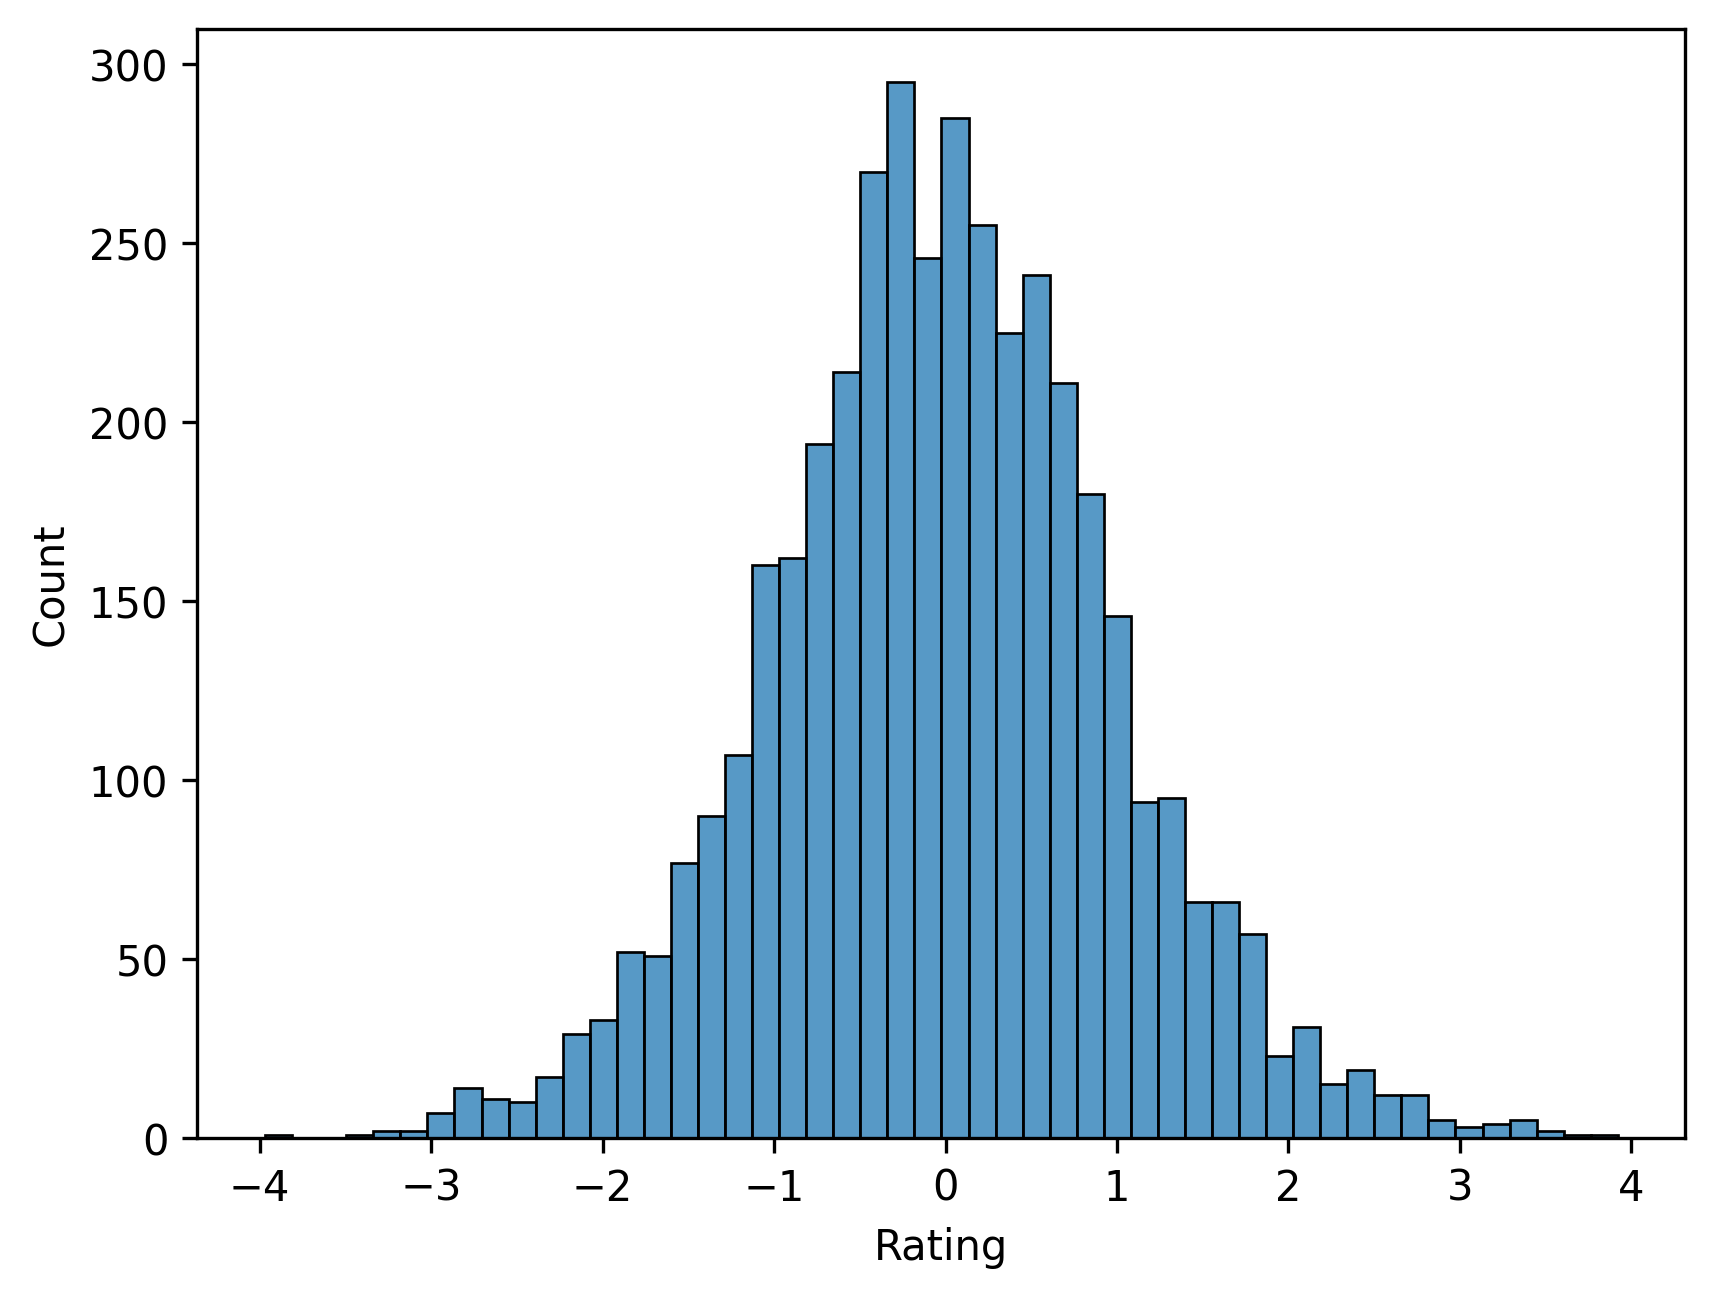

In [23]:
plt.figure(dpi=300)
sb.histplot(predictions - y_test)
plt.show()

In [24]:
# mean absolute error:
np.abs(predictions - y_test).mean()

0.787206806488315

A mean absolute error of 0.8 for ratings from 1 to 5 is not a spectacularly good result, but it isn't bad either. There is one very particular problem due to the linear regression model though:

In [25]:
predictions.min(), predictions.max()

(-1.8632384891273492, 7.2737304843207395)

#### Prediction of impossible values
The linear regression model has no bounds and could in principle output any float value. Here we got impossible negative values and ratings > 5. This could of course be fixed by simply adding an additional line of code that sets all values < 1 to 1 and all values > 5 to 5.

In [26]:
predictions[predictions < 1] = 1
predictions[predictions > 5] = 5

print(f"Mean absolute error after clipping the predictions: {np.abs(predictions - y_test).mean()}")

Mean absolute error after clipping the predictions: 0.6740048418378741


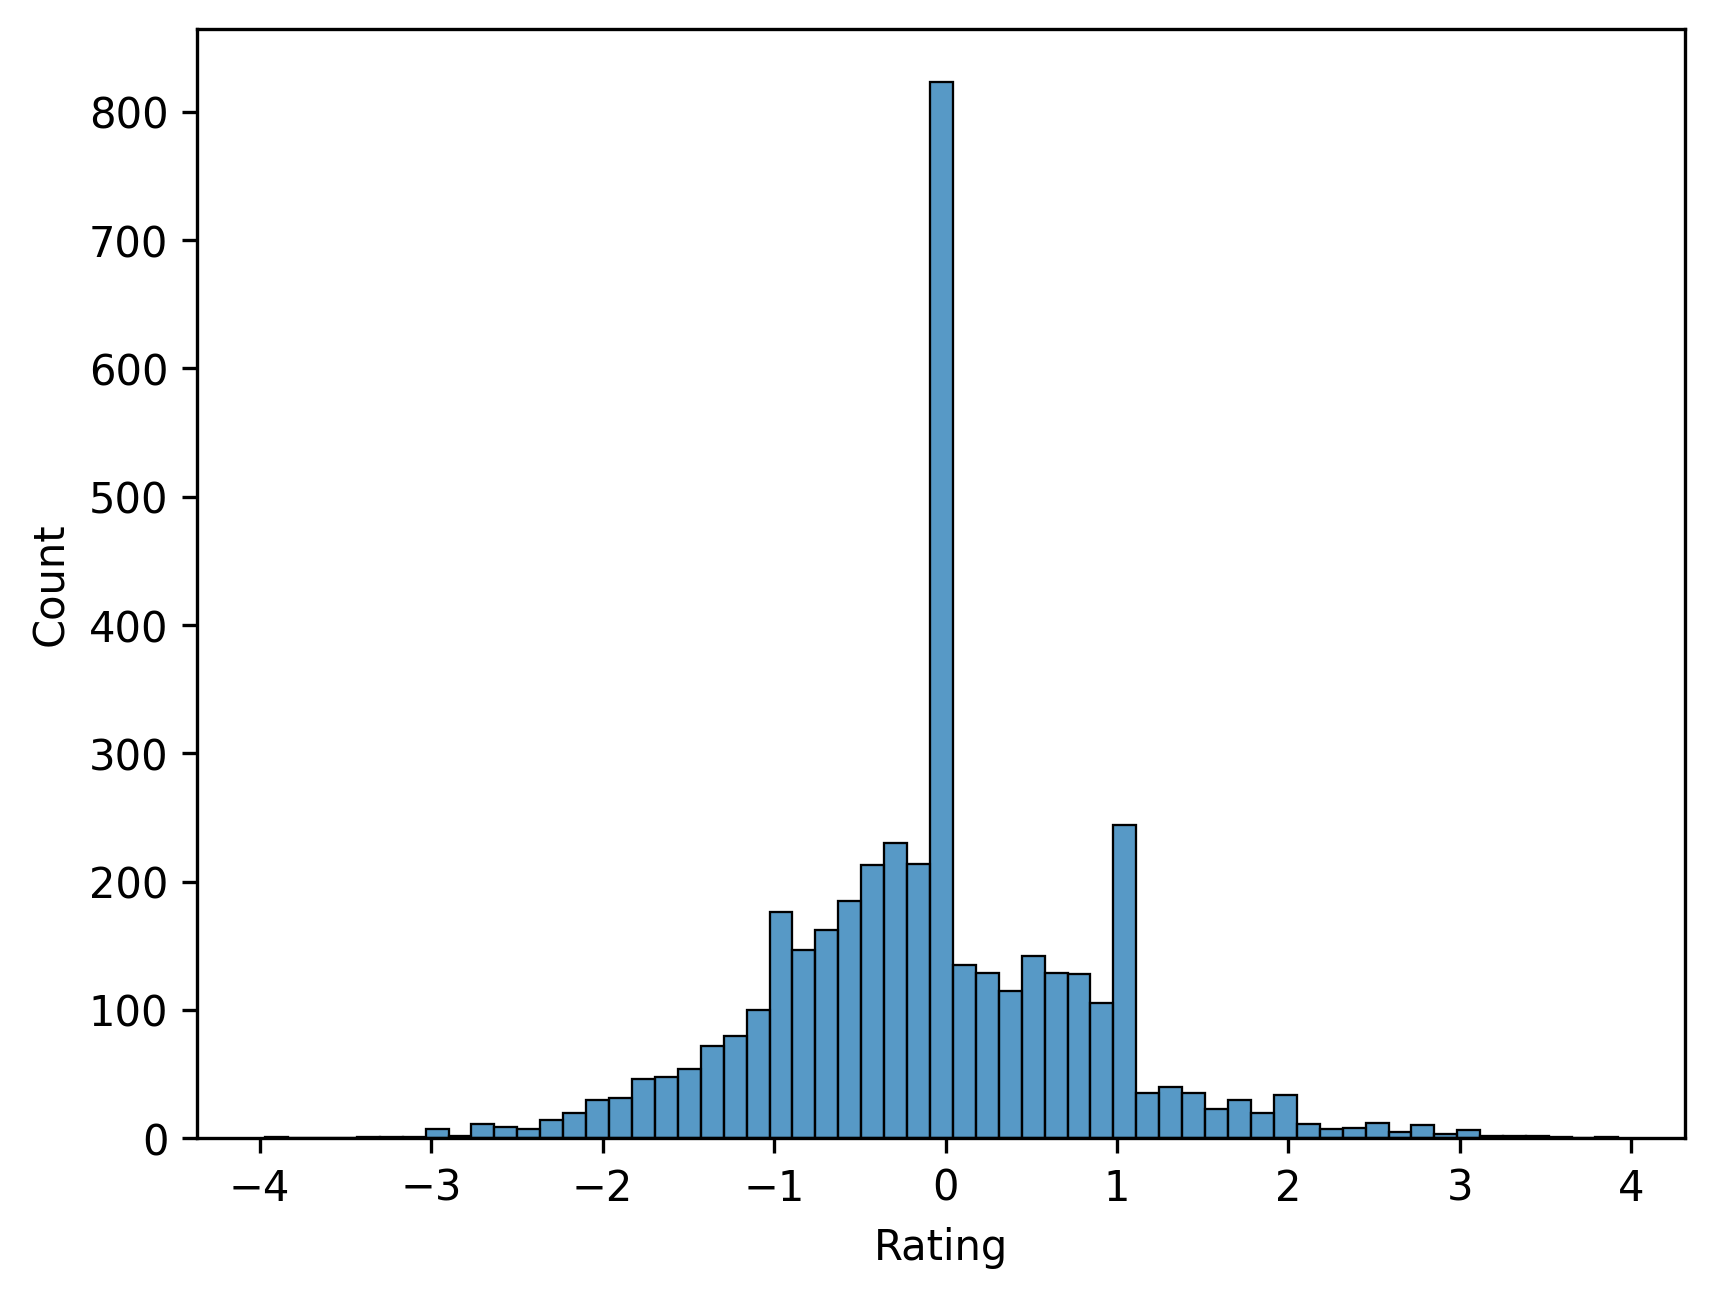

In [27]:
plt.figure(dpi=300)
sb.histplot(predictions - y_test)
plt.show()

Interestingly, this clipping step improved the quality of the predictions notably which can both be seen in the mean absolute error (MAE) and the error distribution.

### Logistic Regression model
We will now use the logistic regression model. Remember, despite its name this is a model use for classification and not regression.

Hint: In the following coding parts, please don't worry if you get warnings about reaching the iterations limit. If you want, you can add a higher `max_iter` value (the Scikit-Learn default value is `100`).

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(tfidf_vectors, y_train)

LogisticRegression(max_iter=1000)

In [29]:
tfidf_vectors_test = tfidf.transform(X_test)

predictions = model.predict(tfidf_vectors_test)

In [30]:
np.round(predictions[:20], 1)

array([2, 4, 5, 5, 4, 5, 5, 2, 5, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 5],
      dtype=int64)

In [31]:
y_test[:20].values

array([2, 2, 4, 5, 3, 5, 4, 3, 4, 5, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5],
      dtype=int64)

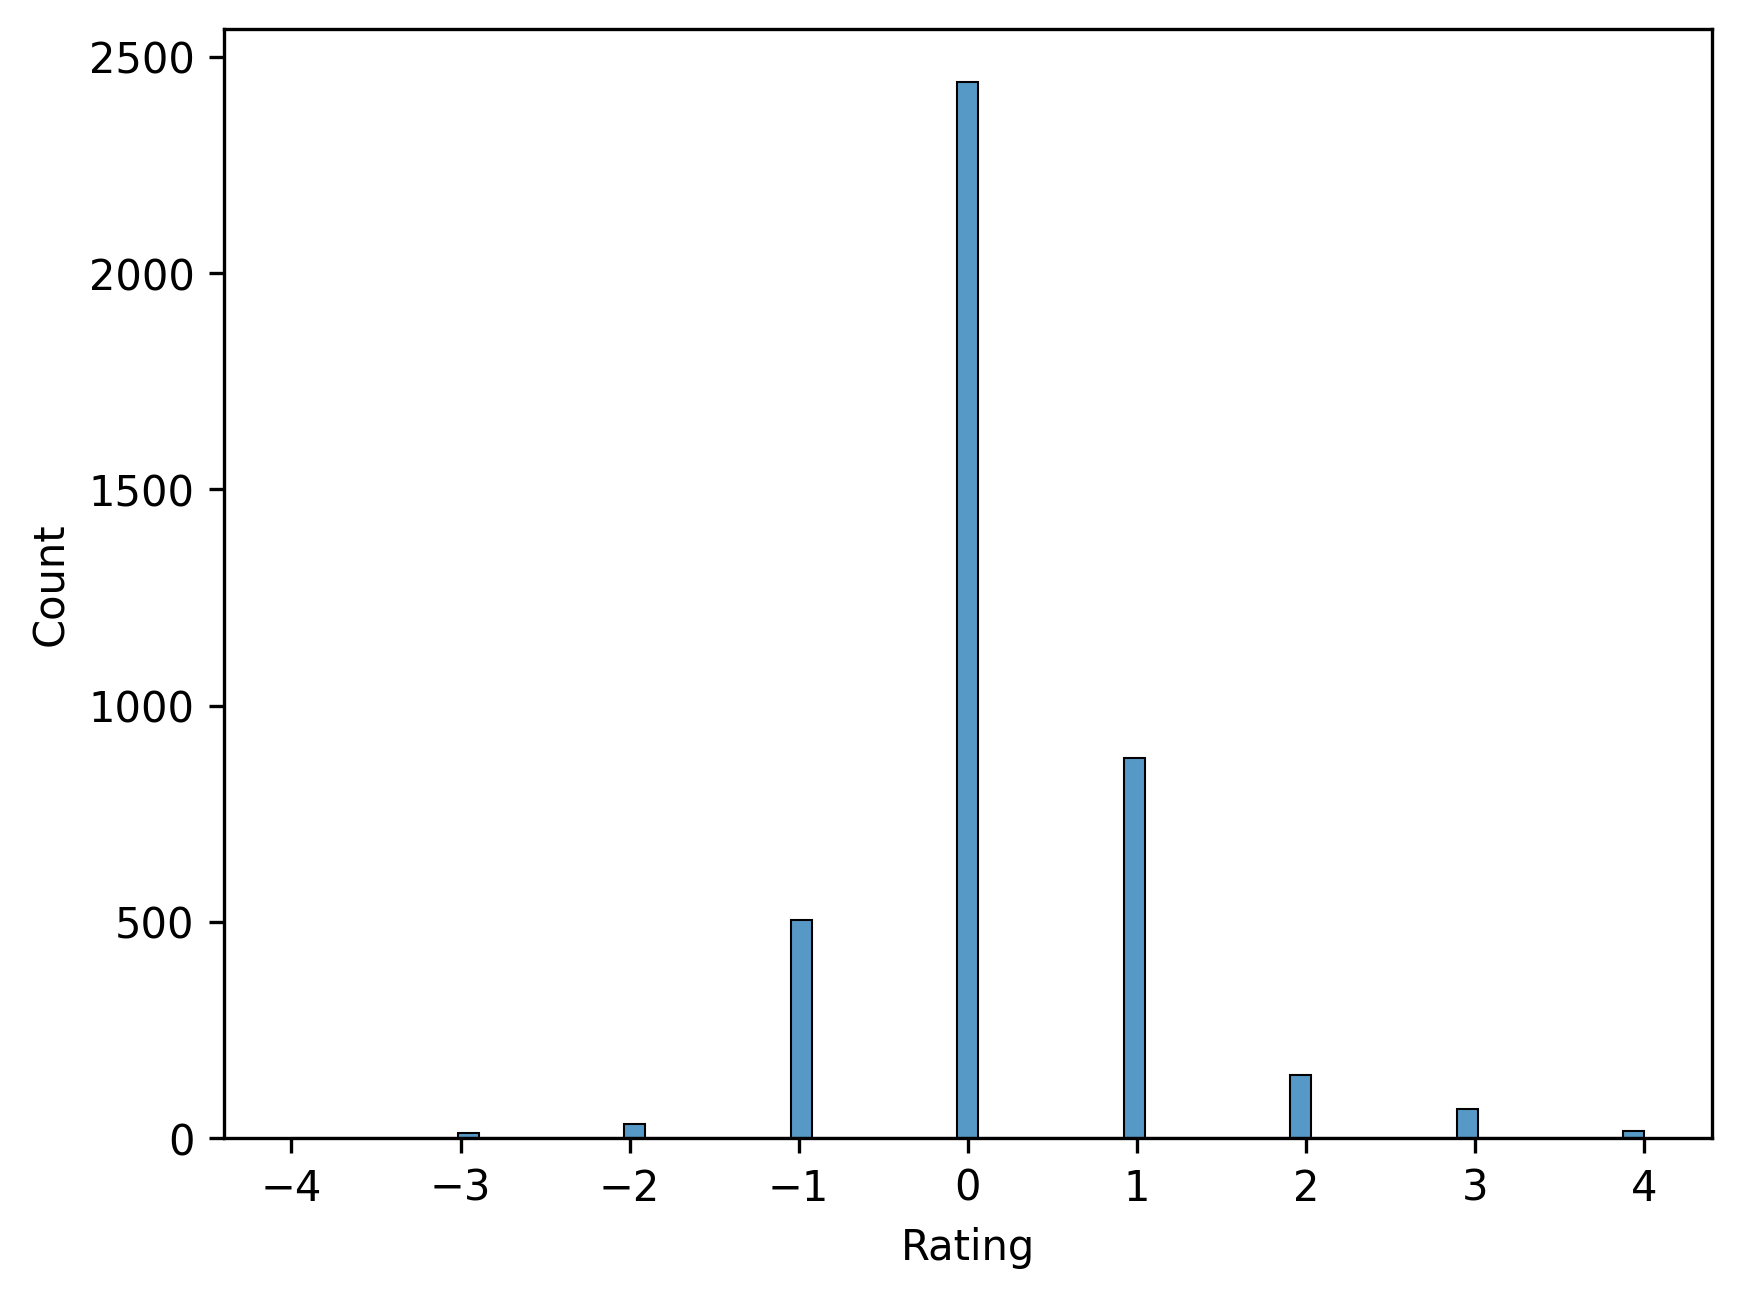

In [32]:
plt.figure(dpi=300)
sb.histplot(predictions - y_test)
plt.show()

In [33]:
# mean absolute error:
np.abs(predictions - y_test).mean()

0.4989021712612832

### Back to: regression vs. classification
For a classification task it usually does not make sense to compute mean absolute errors. But here it does. And it allows us to compare the performance of the linear regression vs. the logistic regression model. And, as spoiled above, the classification task does indeed result in better predictions!

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 166   66    7   30   16]
 [  59  120   61   77   38]
 [  12   62  107  229   61]
 [   5   14   48  613  523]
 [   1    6    7  336 1435]]
              precision    recall  f1-score   support

           1       0.68      0.58      0.63       285
           2       0.45      0.34      0.39       355
           3       0.47      0.23      0.31       471
           4       0.48      0.51      0.49      1203
           5       0.69      0.80      0.74      1785

    accuracy                           0.60      4099
   macro avg       0.55      0.49      0.51      4099
weighted avg       0.58      0.60      0.58      4099



### Confusion matrix
The confusion matrix can tell us a lot about where the model works well and where it fails. Often is is more accessible if the matrix is plotted, for instance using seaborns `heatmap`.

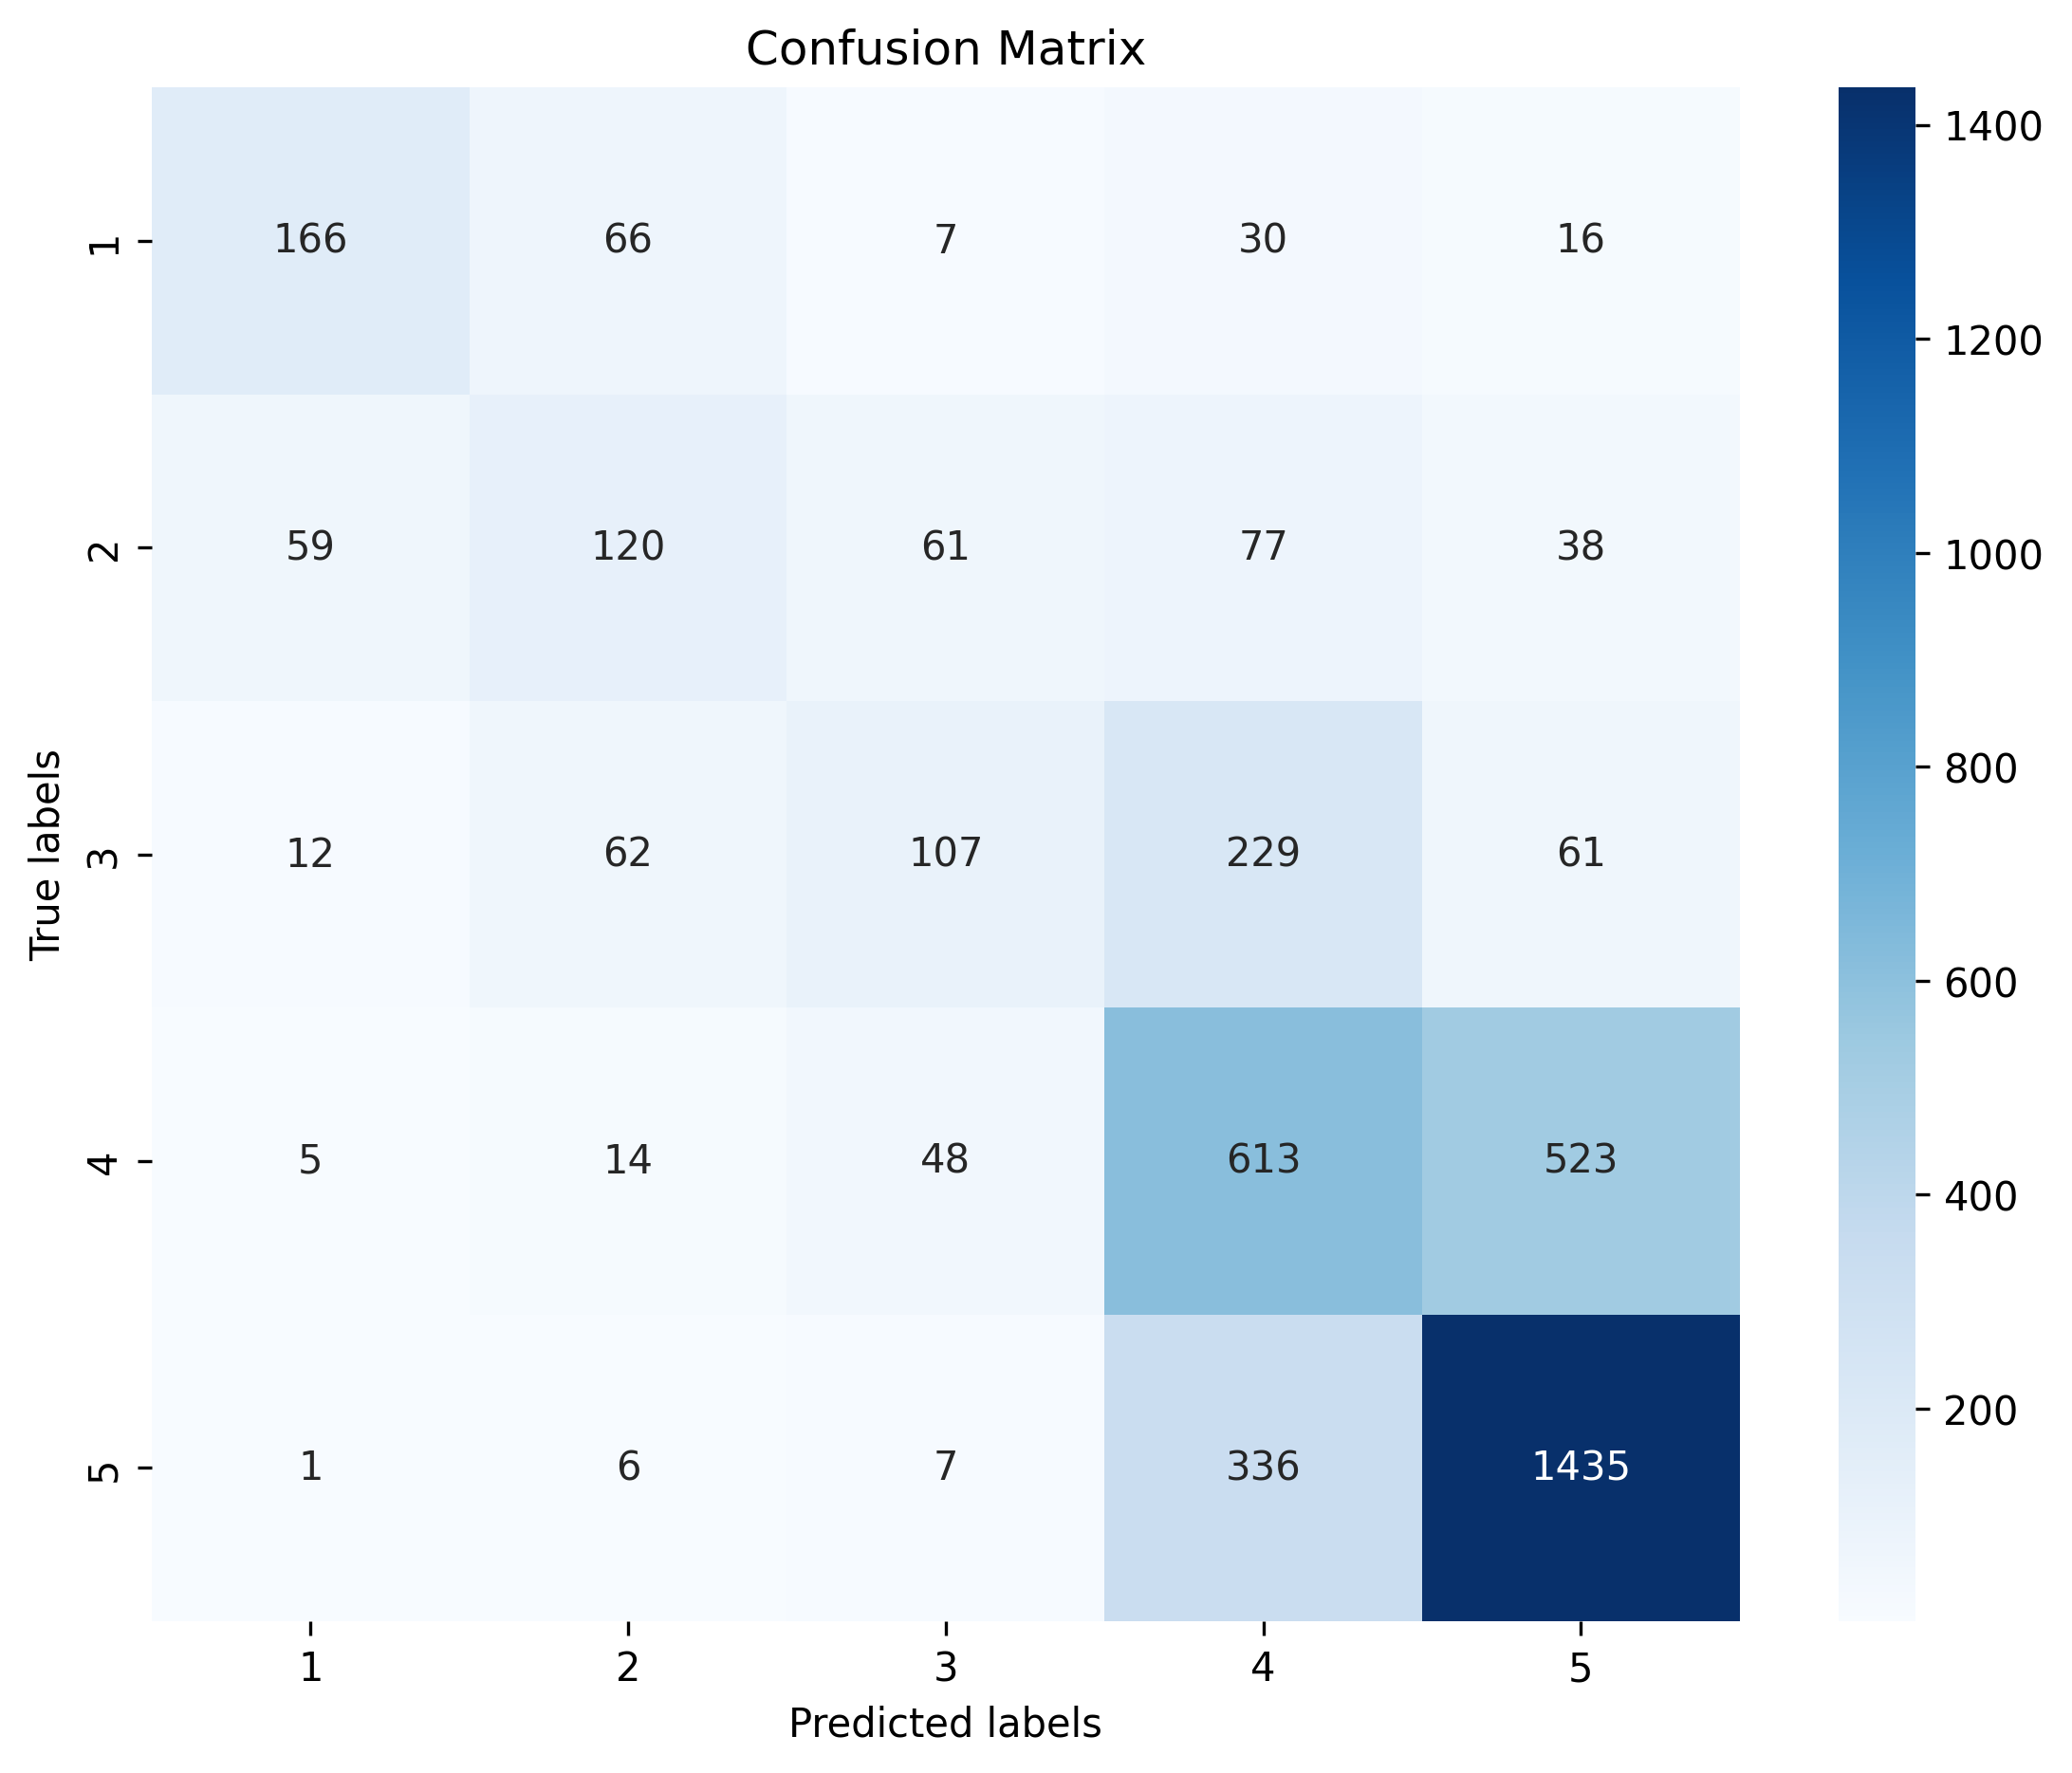

In [35]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Convert your prediction tasks
Sometimes it can help to change the actual prediction task to make it clearer, and thereby simpler, for a machine learning model to learn. In the present case we could for instance say that we convert that ratings 1 to 5 into only three categories: bad (1 or 2), neutral (3), or good (4 or 5).

This is of course less nuanced, but it can make it an easier classification task.

In [36]:
# Change the rating to Good - Neutral - Bad
def convert_rating(score):
    if score > 3:
        return 'good'
    if score == 3:
        return 'neutral'
    return 'bad'

data["rating_simplified"] = data['Rating'].apply(convert_rating)
data.head()

,S.No.,Review,Rating,rating_simplified
0,1,nice hotel expensive parking got good deal sta...,4,good
1,2,ok nothing special charge diamond member hilto...,2,bad
2,3,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,4,unique \tgreat stay \twonderful time hotel mon...,5,good
4,5,great stay great stay \twent seahawk game awes...,5,good


In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['Review'],
    data["rating_simplified"],
    test_size=0.2,
    random_state=0)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")    

Train dataset size: (16392,)
Test dataset size: (4099,)


In [38]:
tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(X_train)
tfidf_vectors.shape

(16392, 46813)

In [39]:
model = LogisticRegression(max_iter=1000)
model.fit(tfidf_vectors, y_train)

LogisticRegression(max_iter=1000)

In [40]:
tfidf_vectors_test = tfidf.transform(X_test)

predictions = model.predict(tfidf_vectors_test)

In [41]:
predictions[:20]

array(['bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good'], dtype=object)

In [42]:
y_test[:20].values

array(['bad', 'bad', 'good', 'good', 'neutral', 'good', 'good', 'neutral',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good'], dtype=object)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 504  108   28]
 [  20 2926   42]
 [  99  296   76]]
              precision    recall  f1-score   support

         bad       0.81      0.79      0.80       640
        good       0.88      0.98      0.93      2988
     neutral       0.52      0.16      0.25       471

    accuracy                           0.86      4099
   macro avg       0.74      0.64      0.66      4099
weighted avg       0.83      0.86      0.83      4099



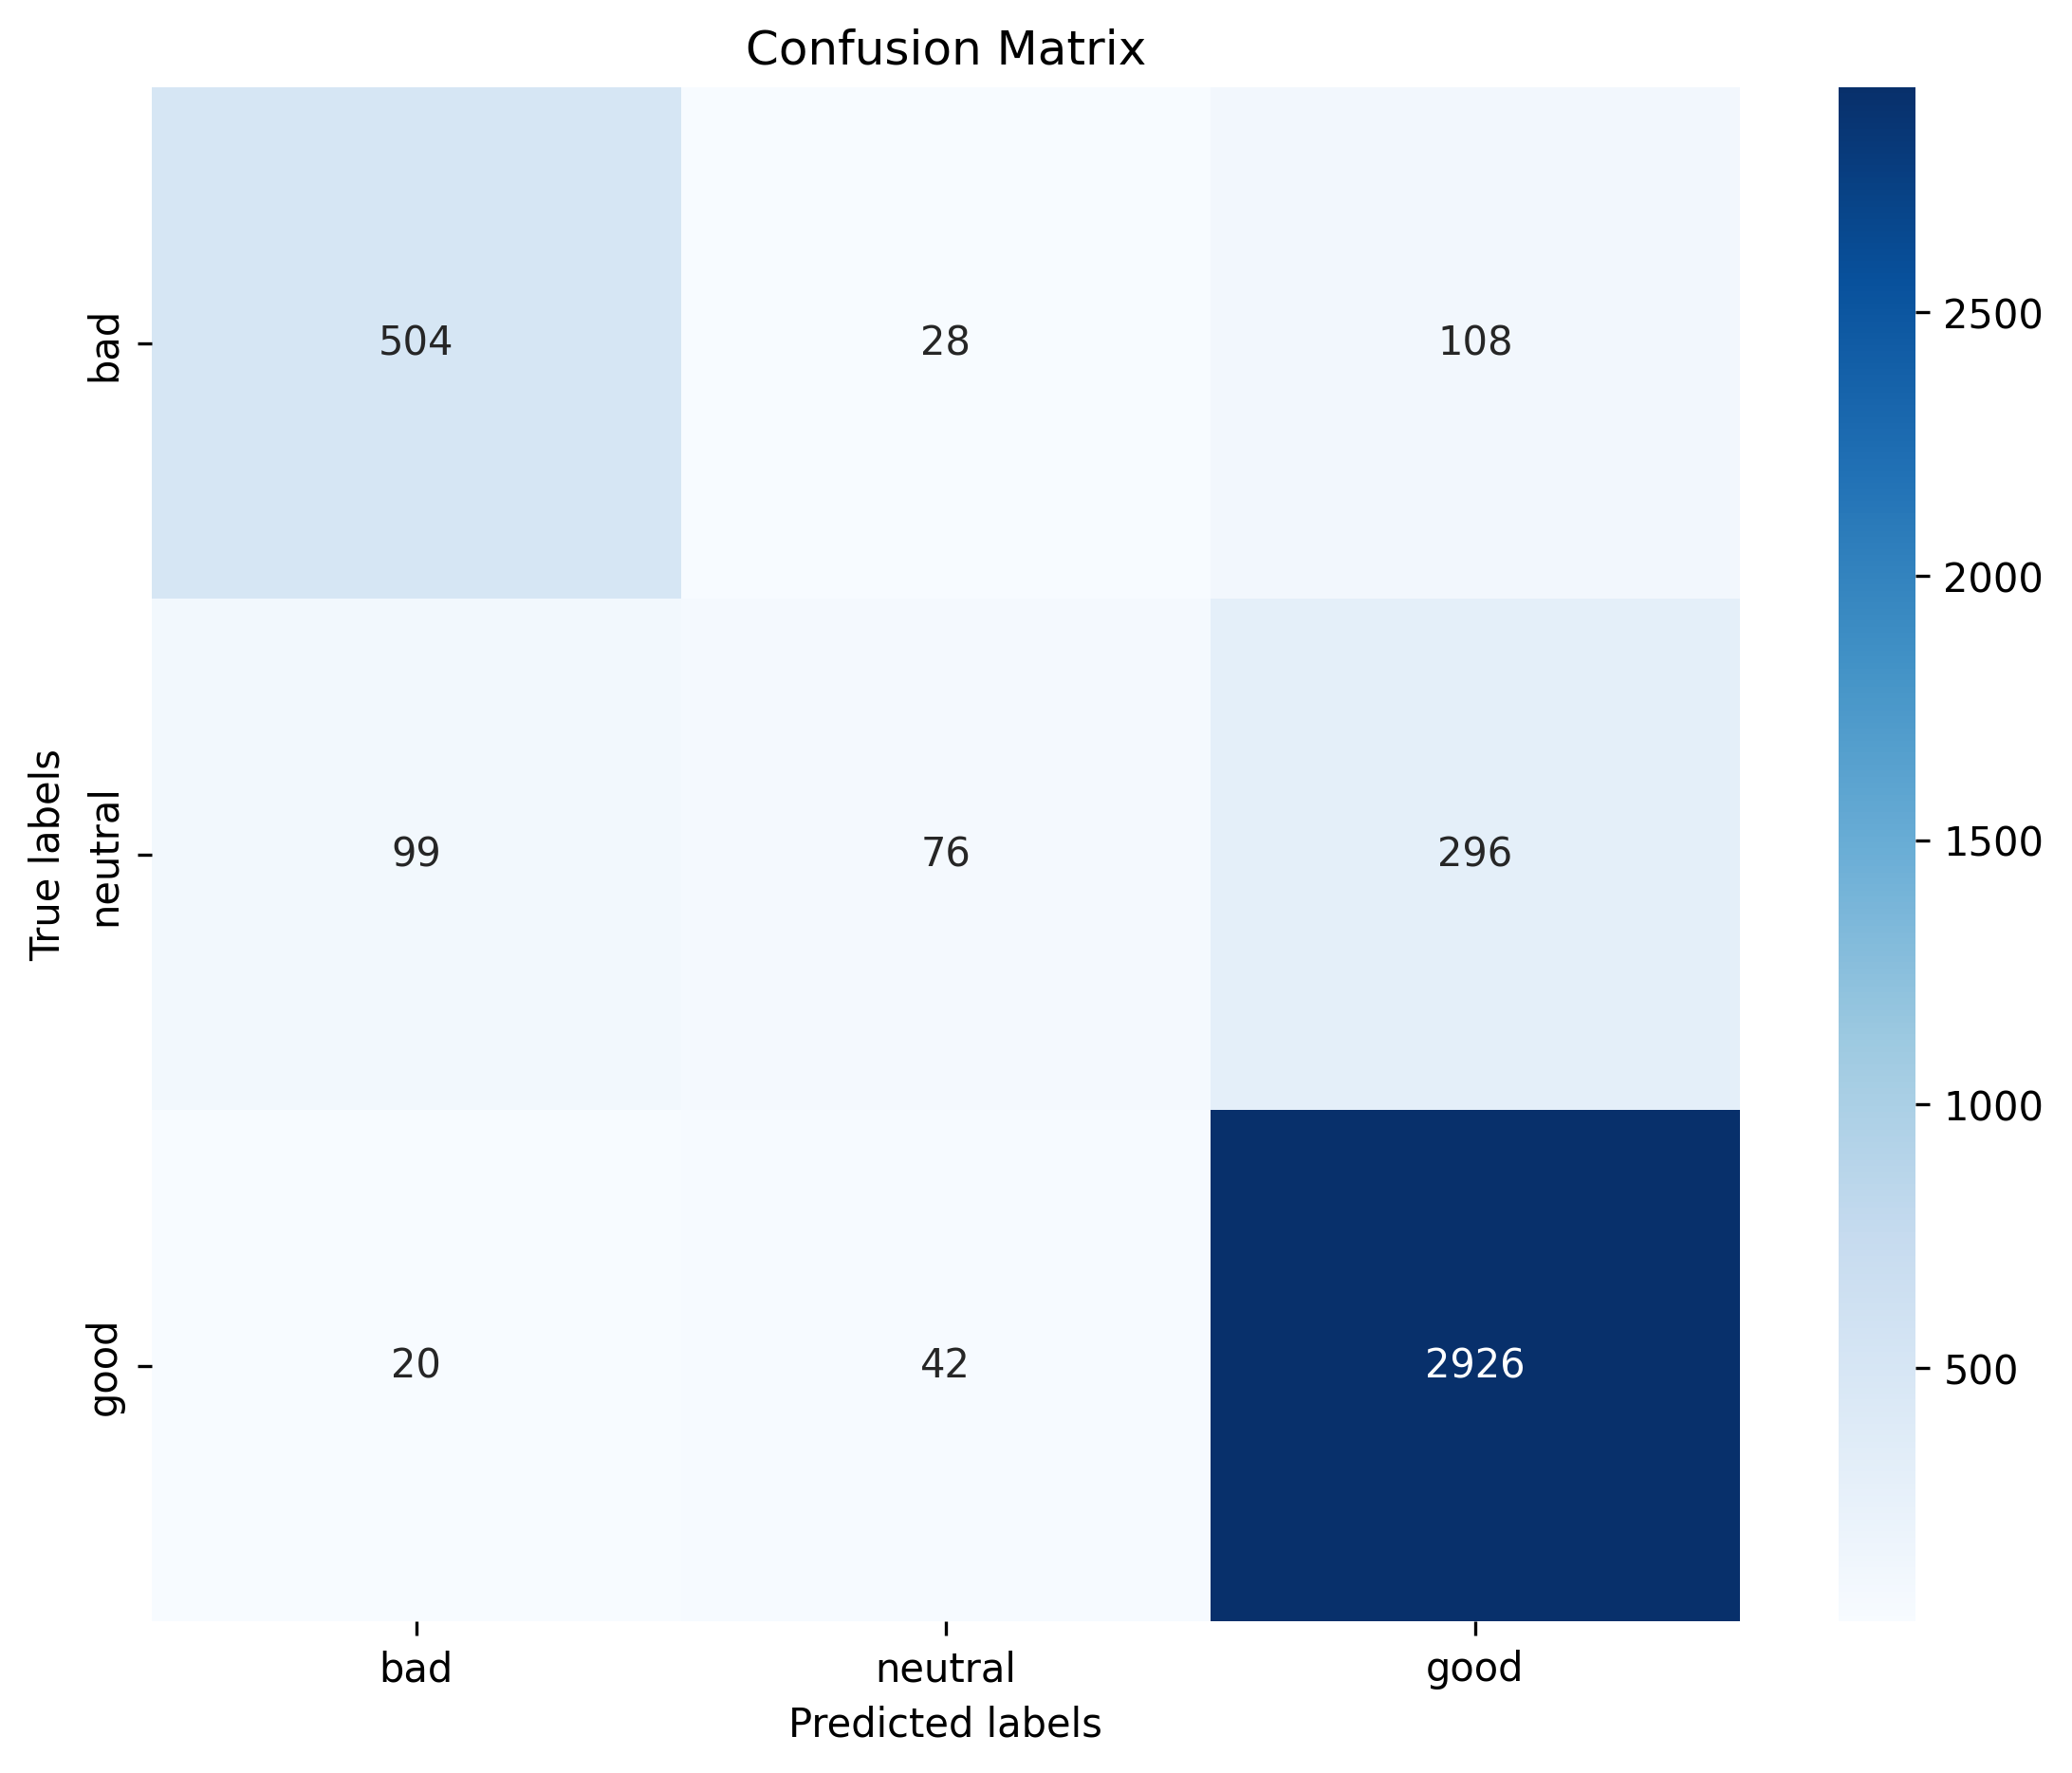

In [44]:
labels = ["bad", "neutral", "good"]
cm = confusion_matrix(y_test, predictions, labels=labels)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=labels,
           yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Question to you:
Judge yourself. Is this a good result? Could this be done better (and if so, how?) ?